In [1]:
!which python

/home/jose/anaconda3/envs/test/bin/python


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [5]:
import pandas as pd

In [6]:
my_data = pd.read_csv('my_data/fake_data.csv')

In [7]:
my_data.head(20)

,t,obj,x,y,z,vx,vy,vz
0,0,1,-1,-1,-1,-1,-1,-1
1,0,2,-2,0,0,0,2,3
2,1,1,-1,1,1,1,1,3
3,1,2,-2,2,2,2,2,3
4,2,1,-1,3,3,3,1,3
5,2,2,-2,4,4,4,2,3
6,3,1,-1,5,5,5,1,3
7,3,2,-3,6,6,6,2,3
8,4,1,-4,-1,-1,-1,-1,-1
9,4,2,-3,0,0,0,2,3


In [8]:
my_data.shape

(16, 8)

In [9]:
from torch.utils.data import Dataset
import os
import numpy as np
import cv2

In [10]:
class MyCustomDataset(Dataset):
    def __init__(self, csv_file, root_dir: str, transform=None,maxnobjects=2,deep=0,
                nfeatures=6, future_prediction=1):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.maxnobjects = maxnobjects
        self.deep = deep
        self.nfeatures = nfeatures
        self.obj_id = list()
        self.future_prediction = future_prediction

    def __len__(self):
        return self.data['t'].max()-self.data['t'].min() -self.deep+1 -self.future_predicition

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #FOr image        
        data = np.zeros((self.maxnobjects,self.nfeatures, self.deep+1))
        #images = np.zeros((self.maxnobjects,1, self.deep))
        

        for t in range(self.deep+1):
            query_data= self.data[self.data['t']== idx+t].iloc[:,1:]
            objects_ids = np.array(query_data.iloc[:,0])
            for oi,o_id in enumerate(objects_ids):
                #print(o_id, "in ", self.obj_id, "time", t)
                ind = self.obj_id.index(o_id) if o_id in self.obj_id else -1
                if ind != -1:
                    #print("updating ", o_id, " index ", ind)
                    data[ind, :,t] = query_data.iloc[oi,1:]
                else:
                    #print ("current ids", self.obj_id, " adding ", o_id)
                    self.obj_id.append(o_id)
                    new_id = len(self.obj_id)-1
                    #print (new_id, " -> NEW ID")
                    data[new_id, :,t] = query_data.iloc[oi,1:]
            #print(objects_ids)#, query_data.iloc[:,2:-1])
            #nobjects, _ = query_data.shape
            #data[:nobjects,:,t] = query_data.iloc[:,1:]
            #images.append(query_data.iloc[:,-1])
            #images[:nobjects,0,t] = query_data.iloc[:,-1]
        #print(data, data.shape)

        image_path = os.path.join(self.root_dir, 
                                    str(self.future_prediction+1+self.deep)+".jpg")
        image = cv2.imread(image_path)
        #data = np.array(self.data.iloc[idx, 0:-1]).reshape(-1,8)
        sample = {'image': image, 'data': data}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
        

In [11]:
class MyCustomDataset2(Dataset):
    def __init__(self, csv_file, root_dir: str, transform=None,maxnobjects=2,
                nfeatures=6, future_prediction=1):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.maxnobjects = maxnobjects
        self.nfeatures = nfeatures
        self.obj_id = list()
        self.future_prediction = future_prediction

    def __len__(self):
        return self.data['t'].max()-self.data['t'].min()+1 -self.future_prediction

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #FOr image        
        data = np.zeros((self.maxnobjects,self.nfeatures, 1))
        query_data= self.data[self.data['t']== idx].iloc[:,1:]
        objects_ids = np.array(query_data.iloc[:,0])
        for oi,o_id in enumerate(objects_ids):
            ind = self.obj_id.index(o_id) if o_id in self.obj_id else -1
            if ind != -1:
                data[ind, :] = np.array(query_data.iloc[oi,1:]).reshape(self.nfeatures,1)
            else:
                self.obj_id.append(o_id)
                new_id = len(self.obj_id)-1
                data[new_id, :,0] = query_data.iloc[oi,1:]

        image_path = os.path.join(self.root_dir, str(idx+
                            self.future_prediction)+".jpg")
        image = cv2.imread(image_path)
        #data = np.array(self.data.iloc[idx, 0:-1]).reshape(-1,8)
        sample = {'image': image, 'data': data}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [12]:
from torchvision import transforms, utils
from skimage import transform 

In [193]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, data = sample['image'], sample['data']

        #h, w = image.shape[:2]
        #if isinstance(self.output_size, int):
        #    if h > w:
        #        new_h, new_w = self.output_size * h / w, self.output_size
        #    else:
        #        new_h, new_w = self.output_size, self.output_size * w / h
        #else:
        #    new_h, new_w = self.output_size

        new_h, new_w = 256,256 #int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        #data = data * [new_w / w, new_h / h]

        return {'image': img, 'data': data}

class Normalize(object):
    def __init__(self):
        pass
        #self.norm = transform.Normalize()
        
    def __call__(self, sample):
        image, data = sample['image'], sample['data']
        image = image/255

        return {'image': image,
                'data': data}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, data = sample['image'], sample['data']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'data': torch.from_numpy(data)}

#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [194]:
#FROM TUTORIAL
mytransform=transforms.Compose([
                                Rescale(256),
                                Normalize(),
                                ToTensor()
                               ])

In [195]:
#FOr testing
#shape maxobject, nfeatures, deep
my_train_dataset = MyCustomDataset2("my_data/fake_data.csv", "my_data/images/train", 
                                    transform=mytransform)

In [196]:
my_test_dataset = MyCustomDataset2("my_data/fake_testdata.csv", "my_data/images/test", 
                                   transform=mytransform)

In [175]:
len(my_train_dataset)

7

In [197]:
for i in range(len(my_train_dataset)):
    print("INLINE", my_train_dataset[i]['image'].shape)

INLINE torch.Size([3, 256, 256])
INLINE torch.Size([3, 256, 256])
INLINE torch.Size([3, 256, 256])
INLINE torch.Size([3, 256, 256])
INLINE torch.Size([3, 256, 256])
INLINE torch.Size([3, 256, 256])
INLINE torch.Size([3, 256, 256])


In [198]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(my_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(my_test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [199]:
len(trainloader), len(testloader)

(2, 2)

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [201]:
def imshow2(images):
    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1,2,0)))

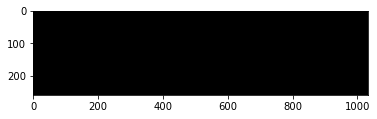

In [205]:
# get some random training images
dataiter = iter(trainloader)
newdata = dataiter.next()
images, data, = newdata["image"], newdata["data"]
# show images
#imshow(images[0])
#print (images[0].shape)
imshow2(images)
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [206]:
dataiter = iter(trainloader)
newdata = dataiter.next()
test_image, test_data = newdata["image"].to(device, dtype=torch.float), newdata["data"].to(device, dtype=torch.float)

In [207]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.uconv1 = nn.ConvTranspose2d(2,10,kernel_size=(3,3))
        self.uconv2 = nn.ConvTranspose2d(10,40,kernel_size=(5,5))
        self.uconv3 = nn.ConvTranspose2d(40,3, kernel_size=(10,10))
        self.up1 = nn.Upsample(size=(256,256))#,scale_factor = 10)

        #(2,10,kernel_size=3)

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
    
    def test(self,x):
        print (x.shape)
        x1 =  self.uconv3(self.uconv2(self.uconv1(x)))
        print (x1.shape)
        print (self.up1(x1).shape)

    def forward(self, input1):
        x = F.relu(self.uconv1(input1))
        x = F.relu(self.uconv2(x))
        x = F.relu(self.uconv3(x))
        output1 = F.sigmoid(self.up1(x))

        x2 = torch.flatten(input1, 1) # flatten all dimensions except batch
        x2 = F.sigmoid(self.fc1(x2))
        x2 = F.relu(self.fc2(x2))
        x2 = F.sigmoid(self.fc3(x2))
        return [output1, x2]


In [208]:
net = Net().to(device)
print(net)

Net(
  (uconv1): ConvTranspose2d(2, 10, kernel_size=(3, 3), stride=(1, 1))
  (uconv2): ConvTranspose2d(10, 40, kernel_size=(5, 5), stride=(1, 1))
  (uconv3): ConvTranspose2d(40, 3, kernel_size=(10, 10), stride=(1, 1))
  (up1): Upsample(size=(256, 256), mode=nearest)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


In [209]:
output = net(test_data)

/home/jose/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [210]:
output[0].shape, output[1].shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 1]))

In [212]:
import torch.optim as optim

criterion_image = nn.MSELoss(reduction='sum')
criterion_result = nn.MSELoss()

optimizer_image = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [213]:
def validate(model,val_data):
    net.eval()
    val_loss = 0.0
    val_criterion_image = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        for i, data in enumerate(val_data, 0):
            # get the inputs; data is a st of [inputs, labels]
            #inputs, labels = data[0].to(device), data[1].to(device)
            labels, inputs = data["image"].to(device, dtype=torch.float), newdata["data"].to(device, dtype=torch.float)
            
            # zero the parameter gradients
            #optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            print (outputs[0].shape, outputs[1].shape, labels.shape)

            loss = val_criterion_image(outputs[0], labels)
            val_loss +=loss.item()
    return val_loss/len(val_data)
        

In [ ]:
net.train()
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a st of [inputs, labels]
        labels, inputs = data["image"].to(device, dtype=torch.float), data["data"].to(device, dtype=torch.float)

        # zero the parameter gradients
        optimizer_image.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print (outputs[0].shape, outputs[1].shape, labels.shape)
        loss = criterion_image(outputs[0], labels)
        loss.backward()
        optimizer_image.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        if True:#i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f'  %
                  (epoch + 1, i + 1, running_loss / 1))
            running_loss = 0.0

    #val_loss = validate(net, testloader)
    #print('[%d, %5d] epoch loss: %.3f validation loss: %.3f'  %
    #    (epoch + 1, i + 1, epoch_loss / len(trainloader), val_loss))
    #epoch_loss = 0.0

print('Finished Training')

[1,     1] loss: 199418.188
[1,     2] loss: 147384.766
[2,     1] loss: 196513.031
[2,     2] loss: 147384.766
[3,     1] loss: 196513.031
[3,     2] loss: 147384.766
[4,     1] loss: 196513.031
[4,     2] loss: 147384.766
[5,     1] loss: 196513.031
[5,     2] loss: 147384.766
[6,     1] loss: 196513.031
[6,     2] loss: 147384.766
[7,     1] loss: 196513.031
[7,     2] loss: 147384.766
[8,     1] loss: 196513.031
[8,     2] loss: 147384.766
[9,     1] loss: 196513.031
[9,     2] loss: 147384.766
[10,     1] loss: 196513.031
[10,     2] loss: 147384.766
[11,     1] loss: 196513.031
[11,     2] loss: 147384.766
[12,     1] loss: 196513.031
[12,     2] loss: 147384.766
[13,     1] loss: 196513.031
[13,     2] loss: 147384.766
[14,     1] loss: 196513.031
[14,     2] loss: 147384.766
[15,     1] loss: 196513.031
[15,     2] loss: 147384.766
[16,     1] loss: 196513.031
[16,     2] loss: 147384.766
[17,     1] loss: 196513.031
[17,     2] loss: 147384.766
[18,     1] loss: 196513.031
[18

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
count_parameters(net)

In [ ]:
PATH = './demo_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
data = dataiter.next()
labels, inputs = data["image"].to(device, dtype=torch.float), data["data"].to(device, dtype=torch.float)


In [ ]:
# print images
imshow(torchvision.utils.make_grid(labels.to("cpu")))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))


#_, predicted = torch.max(outputs, 1)

#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
 #                             for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for cla#ssname in classes}

In [ ]:
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        labels, inputs = data["image"].to("cpu", dtype=torch.float), data["data"].to("cpu", dtype=torch.float)
        outputs = net(inputs)
        imshow(torchvision.utils.make_grid(outputs[0].to("cpu")))
        #_, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        #for label, prediction in zip(labels, predictions):
        #    if label == prediction:
        #        correct_pred[classes[label]] += 1
        #    total_pred[classes[label]] += 1

In [ ]:
# print accuracy for each class
#for classname, correct_count in correct_pred.items():
##    accuracy = 100 * float(correct_count) / total_pred[classname]
 #   print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))